# Load Libraries and Data
Import libraries, ignore warnings, load the CSV files, and convert datetime columns.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost.callback import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from umap import UMAP
import joblib
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Load the cleaned data
df = pd.read_csv('data/cleaned_retail_data.csv')
rfm = pd.read_csv('data/rfm_data.csv')

# Convert InvoiceDate back to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Print data shapes
print("Data loaded successfully.")
print(f"Main dataset shape: {df.shape}")
print(f"RFM dataset shape: {rfm.shape}")

Data loaded successfully.
Main dataset shape: (393218, 14)
RFM dataset shape: (4300, 3)


# Preprocess Data for Sales Forecasting
Group daily sales, create plot, and add time-based features like lag and rolling windows.

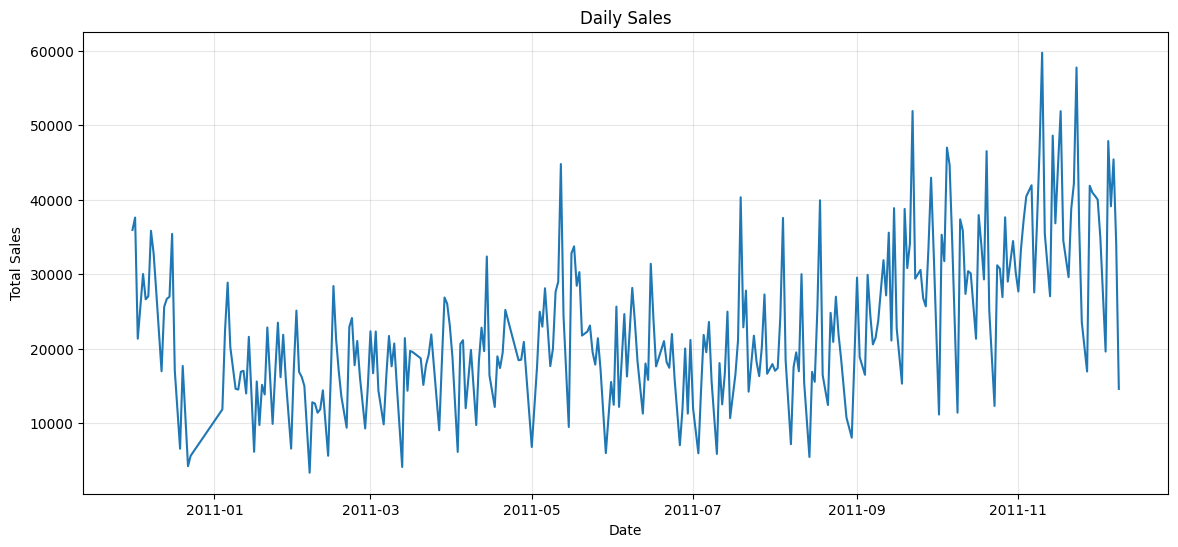

In [12]:
# Group daily sales
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalPrice'].sum().reset_index()
daily_sales['InvoiceDate'] = pd.to_datetime(daily_sales['InvoiceDate'])
daily_sales = daily_sales.rename(columns={'InvoiceDate': 'Date'})

# Sort by date
daily_sales = daily_sales.sort_values('Date')

# Plot daily sales
plt.figure(figsize=(14, 6))
plt.plot(daily_sales['Date'], daily_sales['TotalPrice'])
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True, alpha=0.3)
plt.show()

# Feature Engineering for Time Series
daily_sales['dayofweek'] = daily_sales['Date'].dt.dayofweek
daily_sales['month'] = daily_sales['Date'].dt.month
daily_sales['year'] = daily_sales['Date'].dt.year
daily_sales['day'] = daily_sales['Date'].dt.day
daily_sales['is_weekend'] = (daily_sales['dayofweek'] >= 5).astype(int)

# Create lag features (previous days' sales)
for i in range(1, 8):
    daily_sales[f'lag_{i}'] = daily_sales['TotalPrice'].shift(i)

# Create rolling window features
daily_sales['rolling_mean_3'] = daily_sales['TotalPrice'].rolling(window=3).mean()
daily_sales['rolling_mean_7'] = daily_sales['TotalPrice'].rolling(window=7).mean()
daily_sales['rolling_std_7'] = daily_sales['TotalPrice'].rolling(window=7).std()

# Drop NA values created by lag and rolling features
daily_sales = daily_sales.dropna()

# Train and Evaluate XGBoost Model
Split data, train the XGBoost regressor, evaluate using RMSE, MAE, and R-squared.

In [25]:
# Split into features and target
X = daily_sales.drop(['Date', 'TotalPrice'], axis=1)
y = daily_sales['TotalPrice']

# Create train and validation sets - using past 30 days for validation
train_size = len(X) - 30
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    eval_metric='rmse',
    early_stopping_rounds=20, 
    verbose=100
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)]
)

# Make predictions
y_pred = xgb_model.predict(X_val)

[0]	validation_0-rmse:8517.68519	validation_1-rmse:19512.51019
[1]	validation_0-rmse:8214.22234	validation_1-rmse:19015.36232
[2]	validation_0-rmse:7934.47382	validation_1-rmse:18688.06072
[3]	validation_0-rmse:7648.63491	validation_1-rmse:18056.42381
[4]	validation_0-rmse:7368.42204	validation_1-rmse:17491.56419
[5]	validation_0-rmse:7104.01836	validation_1-rmse:17136.08965
[6]	validation_0-rmse:6851.11760	validation_1-rmse:16686.42034
[7]	validation_0-rmse:6603.89920	validation_1-rmse:16323.40059
[8]	validation_0-rmse:6384.87528	validation_1-rmse:15768.43334
[9]	validation_0-rmse:6160.36523	validation_1-rmse:15462.72670
[10]	validation_0-rmse:5944.95089	validation_1-rmse:15007.75990
[11]	validation_0-rmse:5738.44530	validation_1-rmse:14880.56693
[12]	validation_0-rmse:5551.07117	validation_1-rmse:14626.49458
[13]	validation_0-rmse:5367.16004	validation_1-rmse:14239.23830
[14]	validation_0-rmse:5194.95018	validation_1-rmse:13998.71196
[15]	validation_0-rmse:5030.33214	validation_1-rms

# Evaluating Model

XGBoost Sales Forecasting Results:
RMSE: 8705.92
MAE: 6525.75
R-squared: 0.3290


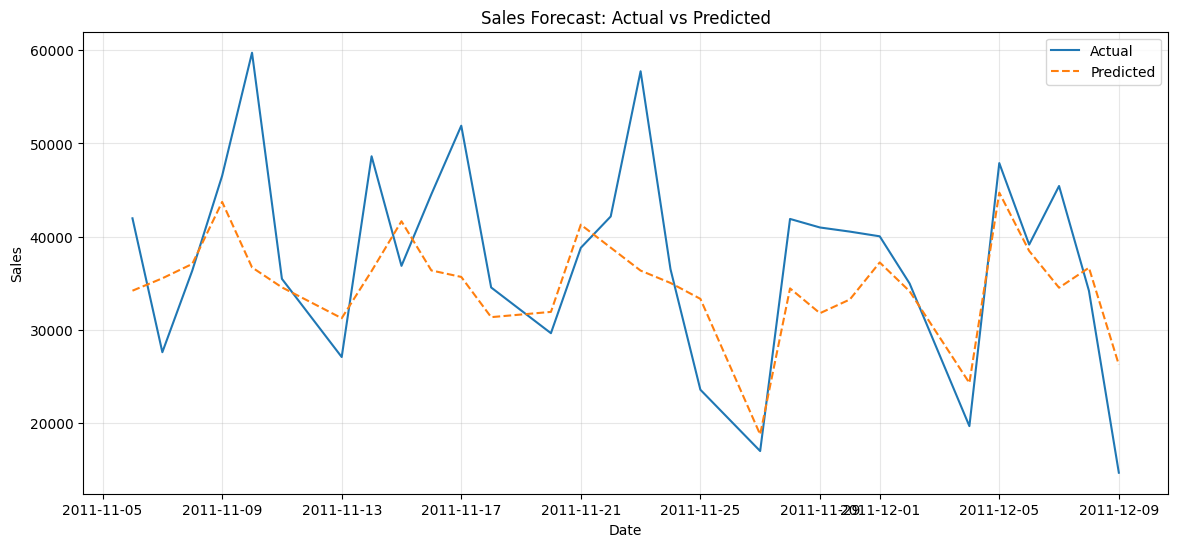

In [26]:
# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"XGBoost Sales Forecasting Results:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R-squared: {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(daily_sales['Date'].iloc[train_size:], y_val, label='Actual')
plt.plot(daily_sales['Date'].iloc[train_size:], y_pred, label='Predicted', linestyle='--')
plt.title('Sales Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Explore Feature Importance
Visualize top features using a bar plot of feature importances.

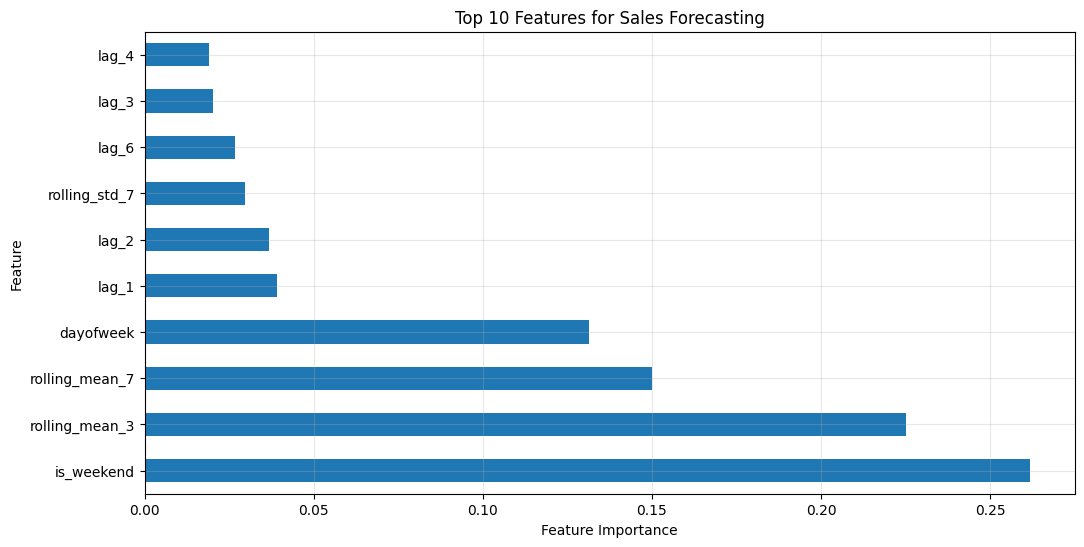

In [27]:
# Explore Feature Importance

# Visualize top features using a bar plot of feature importances
plt.figure(figsize=(12, 6))
feat_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Features for Sales Forecasting')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.grid(True, alpha=0.3)
plt.show()

# Save XGBoost Model
Use joblib to save the trained model to disk for future use.

In [20]:
# Save XGBoost Model

# Use joblib to save the trained XGBoost model to disk for future use
joblib.dump(xgb_model, 'xgb_sales_forecast_model.pkl')

['xgb_sales_forecast_model.pkl']

# Preprocess Data for Customer Segmentation
Scale the RFM data and store the scaler using joblib.

In [28]:
# Preprocess Data for Customer Segmentation

# Prepare RFM data
rfm_data = rfm.copy()
rfm_data = rfm_data.rename(columns={'CustomerID': 'CustomerID'})

# Scale the RFM data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['Recency', 'Frequency', 'MonetaryValue']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'MonetaryValue'])

# Save the scaler for later use
joblib.dump(scaler, 'rfm_scaler.pkl')

['rfm_scaler.pkl']

# K-Means Clustering
Apply K-Means to the scaled data to create a baseline segmentation.

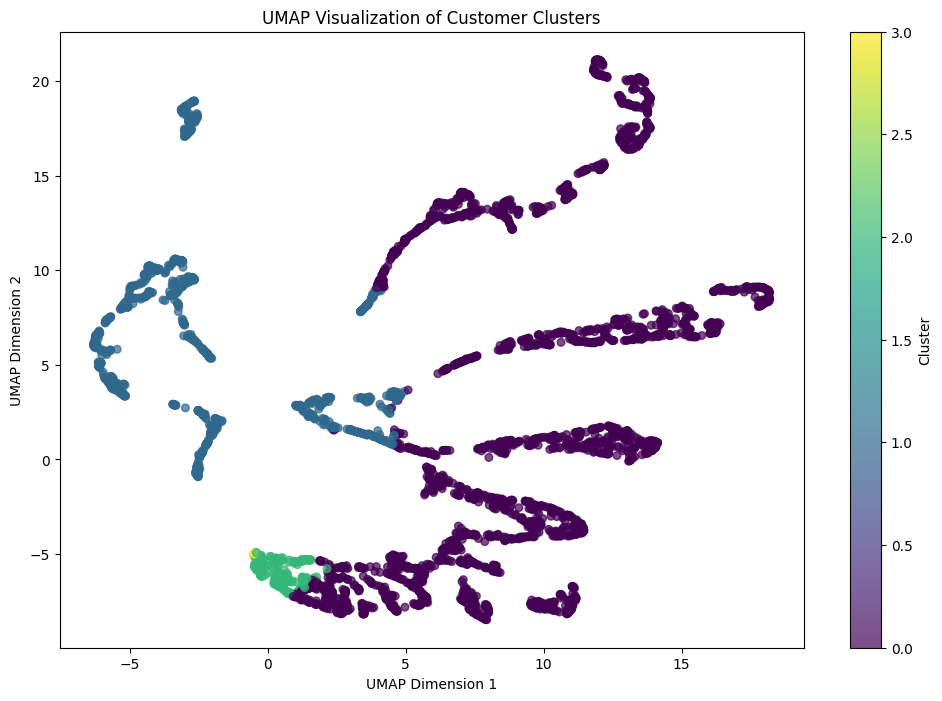

In [29]:
# K-Means Clustering

# Apply K-Means to the scaled data to create a baseline segmentation
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_data['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualize clusters using UMAP for dimensionality reduction
umap_reducer = UMAP(random_state=42)
umap_embedded = umap_reducer.fit_transform(rfm_scaled)

# Plot the clusters
plt.figure(figsize=(12, 8))
plt.scatter(
    umap_embedded[:, 0], 
    umap_embedded[:, 1],
    c=rfm_data['Cluster'], 
    cmap='viridis', 
    s=30, 
    alpha=0.7
)
plt.colorbar(label='Cluster')
plt.title('UMAP Visualization of Customer Clusters')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

# UMAP Visualization
Reduce dimensionality with UMAP and visualize cluster assignments in 2D space.

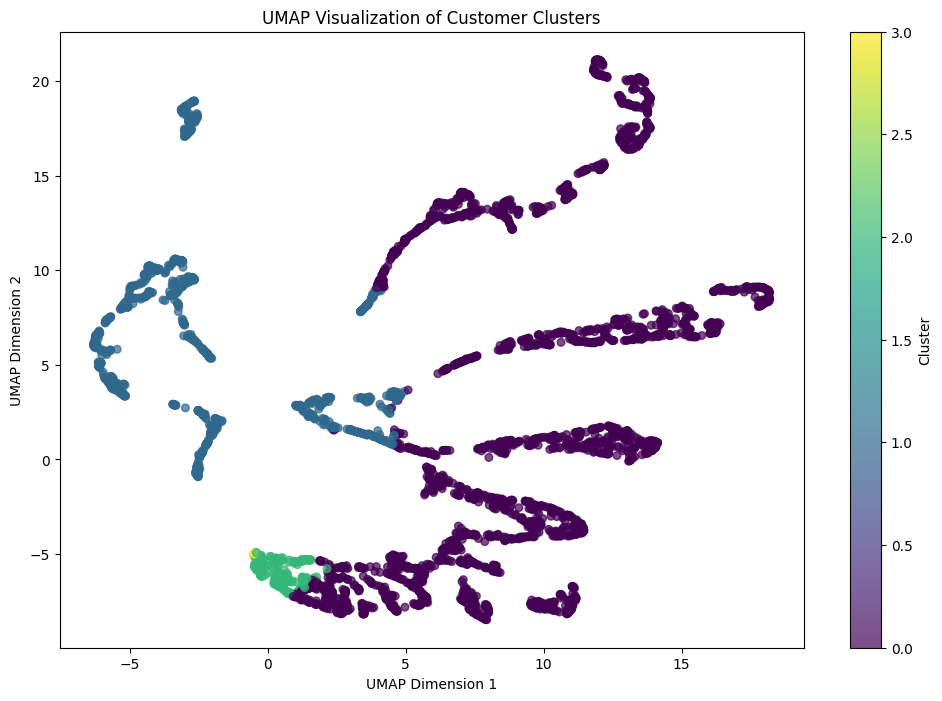

In [30]:
# UMAP Visualization

# Visualize clusters using UMAP for dimensionality reduction
umap_reducer = UMAP(random_state=42)
umap_embedded = umap_reducer.fit_transform(rfm_scaled)

# Plot the clusters
plt.figure(figsize=(12, 8))
plt.scatter(
    umap_embedded[:, 0], 
    umap_embedded[:, 1],
    c=rfm_data['Cluster'], 
    cmap='viridis', 
    s=30, 
    alpha=0.7
)
plt.colorbar(label='Cluster')
plt.title('UMAP Visualization of Customer Clusters')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

# Build and Train Autoencoder
Construct an autoencoder model to learn compressed representations of the RFM data.

Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9559 - val_loss: 0.5927
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6179 - val_loss: 0.4714
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4726 - val_loss: 0.3600
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3566 - val_loss: 0.2863
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2682 - val_loss: 0.2443
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2012 - val_loss: 0.2134
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2037 - val_loss: 0.1852
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2103 - val_loss: 0.1677
Epoch 9/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1430 - val_loss: 0.1546
Epoch 10/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1959 - val_loss: 0.1434
Epoch 11/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1178 - val_loss: 0.1338
Epoch 12/100
108/108 ━━━━━━━━━━━━━━━━━━━━

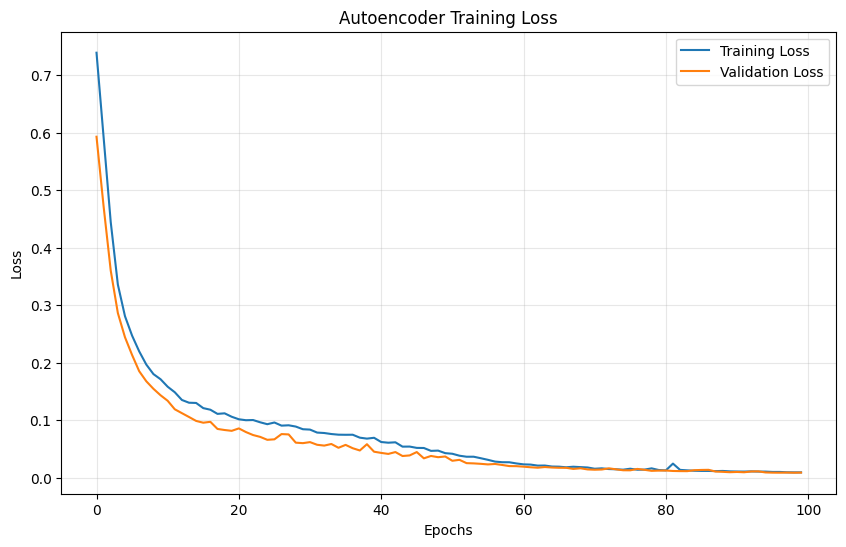

In [31]:
# Build and Train Autoencoder

# Set up the autoencoder architecture
input_dim = rfm_scaled.shape[1]
encoding_dim = 2  # Compressed representation size

# Encoder
input_layer = keras.Input(shape=(input_dim,))
encoder = layers.Dense(8, activation='relu')(input_layer)
encoder = layers.Dense(encoding_dim, activation='relu')(encoder)

# Decoder
decoder = layers.Dense(8, activation='relu')(encoder)
decoder = layers.Dense(input_dim, activation='linear')(decoder)

# Autoencoder model
autoencoder = keras.Model(input_layer, decoder)
encoder_model = keras.Model(input_layer, encoder)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Set up early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the autoencoder
history = autoencoder.fit(
    rfm_scaled, rfm_scaled,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Save the encoder model
encoder_model.save('customer_encoder_model.h5')

# K-Means on Encoded Features
Run K-Means on autoencoder outputs for a refined segmentation approach.

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


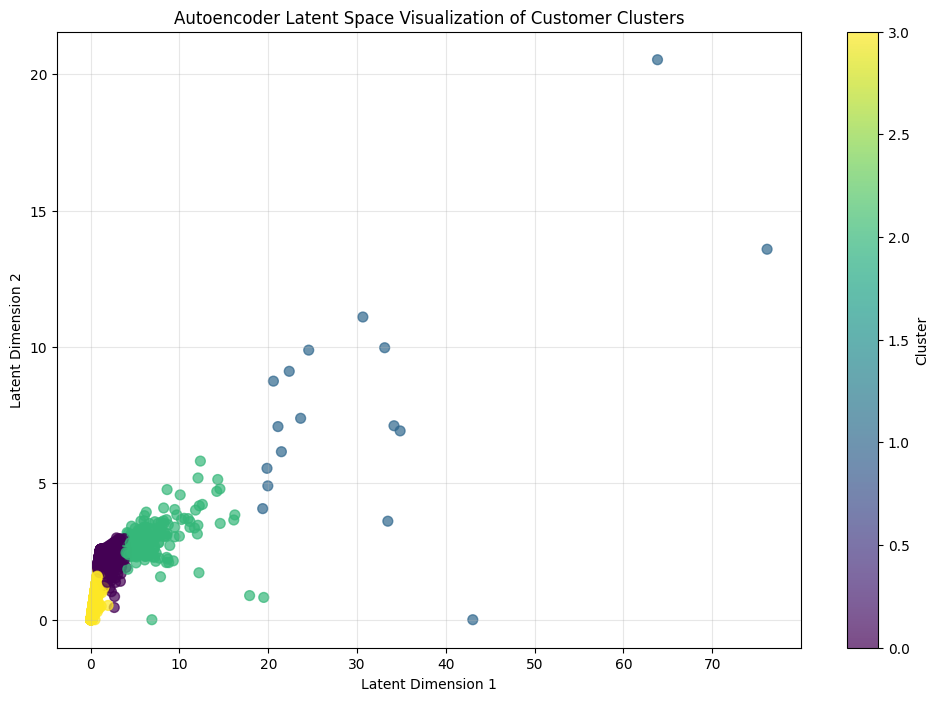

['customer_kmeans_model.pkl']

In [32]:
# K-Means on Encoded Features

# Get the encoded features from the autoencoder
encoded_features = encoder_model.predict(rfm_scaled)

# Apply K-Means clustering on the encoded features
kmeans_encoded = KMeans(n_clusters=4, random_state=42)
rfm_data['AutoEncoder_Cluster'] = kmeans_encoded.fit_predict(encoded_features)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
plt.scatter(
    encoded_features[:, 0], 
    encoded_features[:, 1],
    c=rfm_data['AutoEncoder_Cluster'], 
    cmap='viridis', 
    s=50, 
    alpha=0.7
)
plt.colorbar(label='Cluster')
plt.title('Autoencoder Latent Space Visualization of Customer Clusters')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True, alpha=0.3)
plt.show()

# Save the K-Means model
joblib.dump(kmeans_encoded, 'customer_kmeans_model.pkl')

# Visualize Autoencoder Clusters
Plot encoded features to observe customer segments, and produce descriptive statistics.

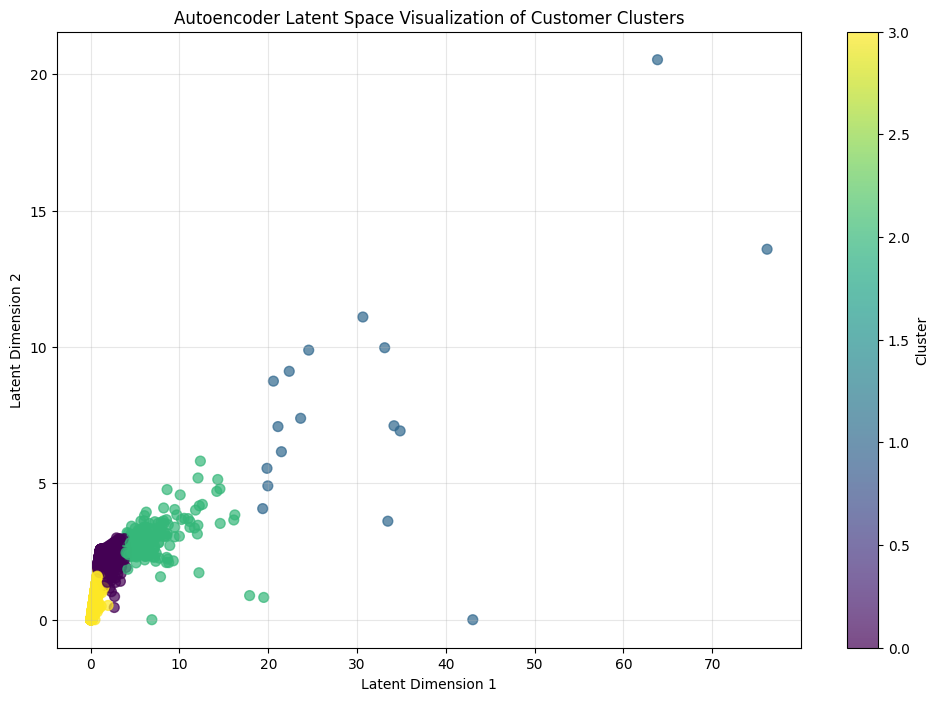


Customer Segment Analysis:


,Cluster,Size,Percentage,Avg_Recency,Avg_Frequency,Avg_MonetaryValue
0,0,2857,66.441860,40.736787,3.600980,1200.556322
1,1,17,0.395349,3.823529,70.529412,58163.985882
2,2,266,6.186047,12.736842,18.454887,7900.252481
3,3,1160,26.976744,236.794828,1.462931,405.445768



Customer Segments with Business Names:


,Cluster,Size,Percentage,Avg_Recency,Avg_Frequency,Avg_MonetaryValue,Segment
0,0,2857,66.441860,40.736787,3.600980,1200.556322,Potential Loyalists
1,1,17,0.395349,3.823529,70.529412,58163.985882,Champions
2,2,266,6.186047,12.736842,18.454887,7900.252481,Champions
3,3,1160,26.976744,236.794828,1.462931,405.445768,At Risk/Lost


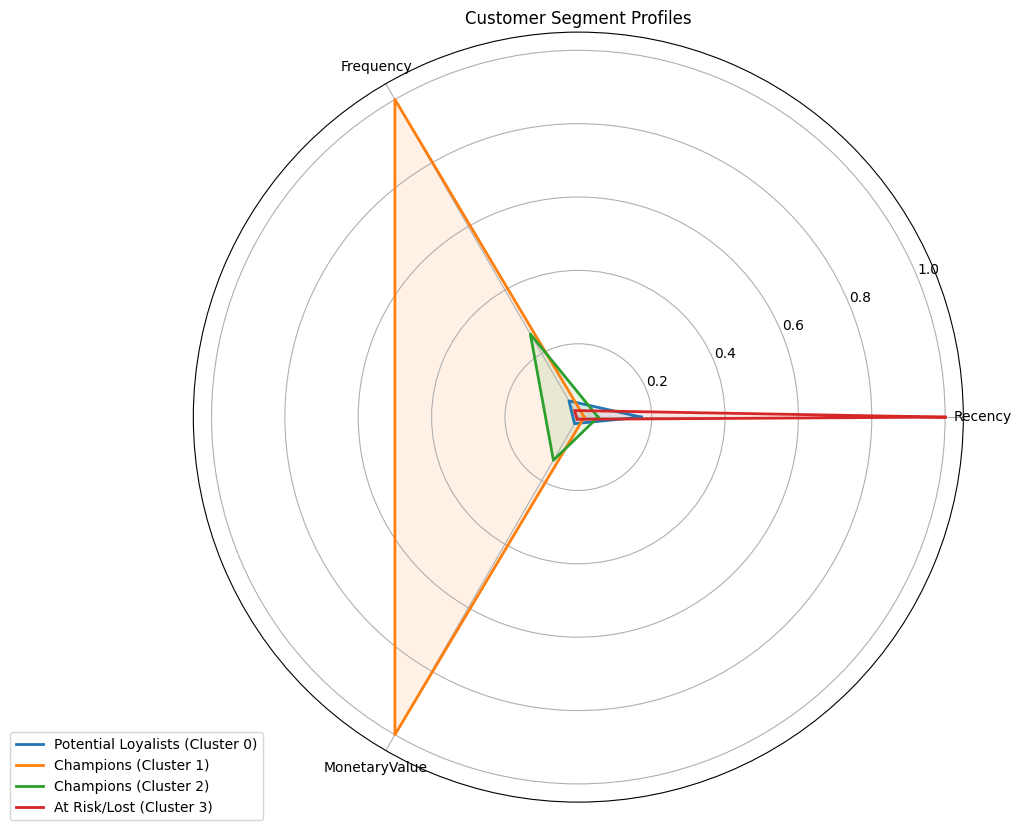

In [33]:
# Visualize Autoencoder Clusters

# Visualize the new clusters
plt.figure(figsize=(12, 8))
plt.scatter(
    encoded_features[:, 0], 
    encoded_features[:, 1],
    c=rfm_data['AutoEncoder_Cluster'], 
    cmap='viridis', 
    s=50, 
    alpha=0.7
)
plt.colorbar(label='Cluster')
plt.title('Autoencoder Latent Space Visualization of Customer Clusters')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate the cluster centers and provide business interpretation
cluster_centers = []
for i in range(4):
    mask = rfm_data['AutoEncoder_Cluster'] == i
    center = rfm_data.loc[mask, ['Recency', 'Frequency', 'MonetaryValue']].mean()
    size = mask.sum()
    percent = 100 * size / len(rfm_data)
    cluster_centers.append({
        'Cluster': i,
        'Size': size,
        'Percentage': percent,
        'Avg_Recency': center['Recency'],
        'Avg_Frequency': center['Frequency'],
        'Avg_MonetaryValue': center['MonetaryValue']
    })

cluster_summary = pd.DataFrame(cluster_centers)
print("\nCustomer Segment Analysis:")
display(cluster_summary)

# Give business names to clusters
def assign_segment_name(row):
    if row['Avg_Recency'] <= 30 and row['Avg_Frequency'] >= 10 and row['Avg_MonetaryValue'] >= 1000:
        return 'Champions'
    elif row['Avg_Recency'] <= 30 and row['Avg_Frequency'] >= 5:
        return 'Loyal Customers'
    elif row['Avg_Recency'] <= 90 and row['Avg_Frequency'] <= 5:
        return 'Potential Loyalists'
    elif row['Avg_Recency'] > 90:
        return 'At Risk/Lost'
    else:
        return 'Needs Attention'

cluster_summary['Segment'] = cluster_summary.apply(assign_segment_name, axis=1)
print("\nCustomer Segments with Business Names:")
display(cluster_summary)

# Radar Chart for Cluster Comparison
from math import pi

categories = ['Recency', 'Frequency', 'MonetaryValue']
N = len(categories)

# Create a figure
fig = plt.figure(figsize=(10, 10))

# Create angles for each category
angles = [n / N * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Prepare axes
ax = plt.subplot(111, polar=True)

# If you have multiple segments
for i, row in cluster_summary.iterrows():
    values = [row['Avg_Recency'], row['Avg_Frequency'], row['Avg_MonetaryValue']]
    
    # Normalize the values for better visualization
    values = [values[0]/max(cluster_summary['Avg_Recency']), 
              values[1]/max(cluster_summary['Avg_Frequency']), 
              values[2]/max(cluster_summary['Avg_MonetaryValue'])]
    
    values += values[:1]  # Close the loop
    
    # Plot the values
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"{row['Segment']} (Cluster {row['Cluster']})")
    ax.fill(angles, values, alpha=0.1)

# Set category labels
plt.xticks(angles[:-1], categories)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Customer Segment Profiles')

plt.show()

# Save Models and Assign Segment Names
Save trained models, map clusters to descriptive segment labels, and store the augmented RFM data.

In [34]:
# Save models
encoder_model.save('customer_encoder_model.h5')
joblib.dump(kmeans_encoded, 'customer_kmeans_model.pkl')

# Add cluster labels back to original RFM data
rfm['Cluster'] = rfm_data['AutoEncoder_Cluster']

# Map the cluster to segment names
cluster_to_segment = {row['Cluster']: row['Segment'] for _, row in cluster_summary.iterrows()}
rfm['Segment'] = rfm['Cluster'].map(cluster_to_segment)

# Save augmented RFM data with clusters
rfm.to_csv('rfm_with_clusters.csv', index=False)

print("Model development complete. Models saved to disk.")

Model development complete. Models saved to disk.
